In [1]:
%matplotlib inline  
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns



def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx <= i are predicted negative while others are predicted positive
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
        new_mcc = mcc(tp, tn, fp, fn)
        mccs[i] = new_mcc
        if new_mcc >= best_mcc:
            best_mcc = new_mcc
            best_id = i
    if show:
        best_proba = y_prob[idx[best_id]]
        y_pred = (y_prob > best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred, mccs
    else:
        return best_mcc

In [2]:
import pandas as pd
import numpy as np
import os, sys, time
import yaml

sys.path.append('/home/ymm/kaggle/xgboost_hyperopt')
import utils
from utils.bosch_functions import load_processed_bosch_data
from utils.models import CombinedModel, ExtraTreeModel
from utils.validation_tools import score_MCC, create_validation_index, cross_validate_model

In [3]:
dep_var_name = 'Response'
raw_models_yaml_file = 'raw_combined_models.yml'
trained_model_yaml_file = 'trained_combined_model.yml'
project_path = '/mnt/home/ymm/kaggle/compete/current/combined_model'
trained_model_yaml_file = 'trained_combined_model.yml'

## load training data
#project_yml_path = '/mnt/home/ymm/kaggle/compete/current'
#data_path = '/mnt/home/ymm/kaggle/bosch_data/bosch_complete_processed_data'
#data_yaml_file = 'bosch_processed_data_dict.yml'

project_path = '/home/ymm/kaggle/compete/current/model_6_bins_data'
data_path = '/home/ymm/kaggle/bosch_data/bosch_complete_processed_6_bins_data'
data_yaml_file = 'complete_subset_data_6_bins_dict.yml'
data_index= '0'
train = load_processed_bosch_data(data_path, project_path, data_yaml_file, data_index=data_index)
train_index, valid_index = create_validation_index(train, 0.4, dep_var_name, True)  
valid_data = train.ix[valid_index]
tmp_train  = train.ix[train_index]

et_params = {'random_state' : 0, 'criterion' : 'entropy', 'n_jobs' : -1, 'n_estimators' : 500, 'max_depth' : 6}
et_model = ExtraTreeModel(et_params)
et_model.fit(tmp_train, dep_var_name)
valid_result = et_model.predict(valid_data)

'''
## train the comined model
combined_model_params = {}
combined_model_params['raw_models_yaml_file'] = raw_models_yaml_file
combined_model_params['project_path'] = project_path
combined_model_params['models_yaml_file'] = trained_model_yaml_file

## initiate a combined model
combined_model = CombinedModel(combined_model_params)
## regular fit and predict
combined_model.fit(tmp_train, dep_var_name)
pred_df = combined_model.predict(valid_data)
#pred_df.to_csv('tmp.csv')
'''

loading bosch data from  /home/ymm/kaggle/bosch_data/bosch_complete_processed_6_bins_data/processed_totBins_6_bin_0_train.csv


"\n## train the comined model\ncombined_model_params = {}\ncombined_model_params['raw_models_yaml_file'] = raw_models_yaml_file\ncombined_model_params['project_path'] = project_path\ncombined_model_params['models_yaml_file'] = trained_model_yaml_file\n\n## initiate a combined model\ncombined_model = CombinedModel(combined_model_params)\n## regular fit and predict\ncombined_model.fit(tmp_train, dep_var_name)\npred_df = combined_model.predict(valid_data)\n#pred_df.to_csv('tmp.csv')\n"

In [4]:
valid_label = valid_data[dep_var_name]

In [5]:
valid_result.head()

Id
477700    0.004535
248658    0.003230
869790    0.004987
591823    0.004444
307810    0.004816
dtype: float64

In [8]:
print valid_label.shape
valid_label[0:10]

(101977,)


Id
432955    0
479560    0
52745     0
296607    0
34315     0
156475    0
106042    0
364804    0
237670    0
164405    0
Name: Response, dtype: int64

In [9]:
print pred_df.shape
pred_df[0:10]

(101977,)


Id
432955    0.017966
479560    0.014284
52745     0.014202
296607    0.013999
34315     0.013869
156475    0.023666
106042    0.016510
364804    0.017289
237670    0.017027
164405    0.015030
dtype: float64

In [7]:
def tmp_score_MCC(ground_truth, scores):
    '''
    assuming the model output is the probability of being default,
    then this probability can be used for ranking. Then using the fraction of
    default in validation data to assign the proper threshold to the prediction
    '''

    if isinstance(scores, pd.Series):
        scores = scores.values

    if isinstance(ground_truth, pd.Series):
        ground_truth = ground_truth.values

    tmp_ground_truth = np.copy(ground_truth)
    fault_frac = tmp_ground_truth.mean()
    #print 'score shape:', scores.shape,
    print 'mean of groud truth:', fault_frac
    thres_value = np.percentile(scores, 100.*(1-fault_frac), axis=0)
    print 'threshold for preds:', thres_value
    binary_scores = scores > thres_value
    binary_scores = binary_scores.astype(int)
    ## convert to sk-learn format
    np.place(binary_scores, binary_scores==0, -1)
    np.place(tmp_ground_truth, tmp_ground_truth==0, -1)

    return matthews_corrcoef(tmp_ground_truth, binary_scores)

In [18]:
tmp_score_MCC(valid_label, pred_df)

mean of groud truth: 0.00641321082205
threshold for preds: 0.0547840873124


0.23207821379419286

In [8]:
tmp_score_MCC(valid_label, valid_result)

mean of groud truth: 0.0053050397878
threshold for preds: 0.108321127485


0.17042424242424251

In [8]:
combo_df = pd.DataFrame()
combo_df['label'] = valid_label
combo_df['pred'] = pred_df

In [10]:
sorted_res_df = combo_df.sort(['pred'], ascending=False)

/mnt/home/ymm/.virtualenvs/kaggle/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [18]:
sorted_pos_valid = combo_df[combo_df.label==1].sort(['pred'], ascending=False)

/mnt/home/ymm/.virtualenvs/kaggle/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [12]:
#sorted_pos_valid

In [13]:
#sorted_res_df.head(30)

In [14]:
valid_label.sum()

654

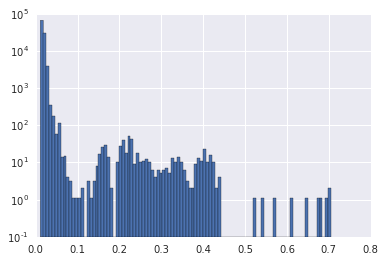

In [22]:
fig, ax = plt.subplots()
pred_df.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

In [42]:
sum(pred_df > best_proba)

30

(0.17324549934742889, 0.17324549934742903)


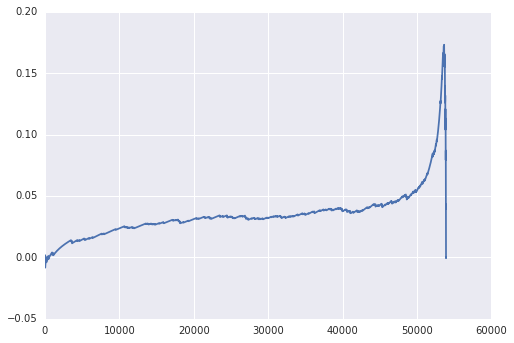

In [10]:
best_proba, best_mcc, y_pred, mccs = eval_mcc(valid_label.values, valid_result.values, True)

In [21]:
print 'expected cut-off threshold based on the #faulted: ', len(mccs) - valid_label.sum()

101323

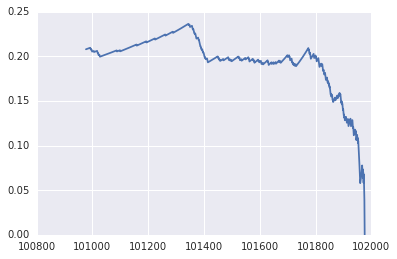

In [54]:
axis = range(len(mccs))
limit = 1000
plt.plot(axis[-limit:], mccs[-limit:])
#plt.plot(x=axis[-50:], y=mccs[-50:])